# *CLIPping at Hate Speech*


## Demo Notebook: Training, Evaluation, Prediction and Attention Rollout

In [1]:
# Imports
import os
import random
import numpy as np
import torch
from torch.utils.data import DataLoader as TorchDataLoader
from DL_vs_HateSpeech.models import ModelV2
from DL_vs_HateSpeech.loading_data.dataloader import DataLoader
from DL_vs_HateSpeech.training.training import collate_fn, get_optimizer_and_criterion, train_epoch
from DL_vs_HateSpeech.evaluation.evaluate import evaluate
from DL_vs_HateSpeech.utils import check_frozen_params, get_label_str
from DL_vs_HateSpeech.attention_rollout.attention_plots import plot_attention_rollout

import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)


/home/jack/anaconda3/envs/ee559/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set seed
def set_seed(seed=42):
    # Python built-ins
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### Configuration

In [3]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Manual config
config = {
    "clip_model_type": "32",
    "hidden_dim": 256,
    "dropout": 0.1,
    "output_dim": 1,  # Binary classification
    "batch_size": 4,
    "epochs": 1,
    "lr": 1e-4,
    "weight_decay": 0.01,
    "augmentation": False,
    "data_subset": "us_pol"
}

Using device: cuda


In [4]:
# Load data
train_dataset = DataLoader(type="train", subset=config["data_subset"])
val_dataset = DataLoader(type="test", subset=config["data_subset"])

train_loader = TorchDataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, collate_fn=collate_fn)
val_loader = TorchDataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, collate_fn=collate_fn)

In [5]:
# Initialize model
model = ModelV2(
    clip_model_type=config["clip_model_type"],
    hidden_dim=config["hidden_dim"],
    dropout=config["dropout"],
    output_dim=config["output_dim"]
).to(device)

optimizer, criterion = get_optimizer_and_criterion(model, lr=config["lr"], weight_decay=config["weight_decay"])

# Print number of trainable params
check_frozen_params(model, print_layers=False)

Trainable params: 4473089, Frozen params: 151277313


### Training and Evaluation

In [6]:
# One epoch training
print("\n== Training ==")
model.train()
train_loss = train_epoch(
    model, train_loader, optimizer, criterion, device, augmentation=config["augmentation"]
)
print(f"Train Loss: {train_loss:.4f}")


== Training ==


Training: 100%|██████████| 735/735 [01:09<00:00, 10.54it/s]

Train Loss: 0.6717


In [7]:
# Evaluation
print("\n== Evaluation ==")
val_loss, accuracy, f1 = evaluate(model, val_loader, criterion, device)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Scores: {f1[0]:.4f}, {f1[1]:.4f}") 


== Evaluation ==


Evaluating: 100%|██████████| 89/89 [00:08<00:00, 10.77it/s]

Validation Loss: 0.6650
Accuracy: 62.25%
F1 Scores: 0.6105, 0.6339


### Prediction and Attention Rollout


== Single Prediction ==
Input Text: ['Bruh why this tub of margarine look like\nDonald Trump?\n'] 

Input Image:


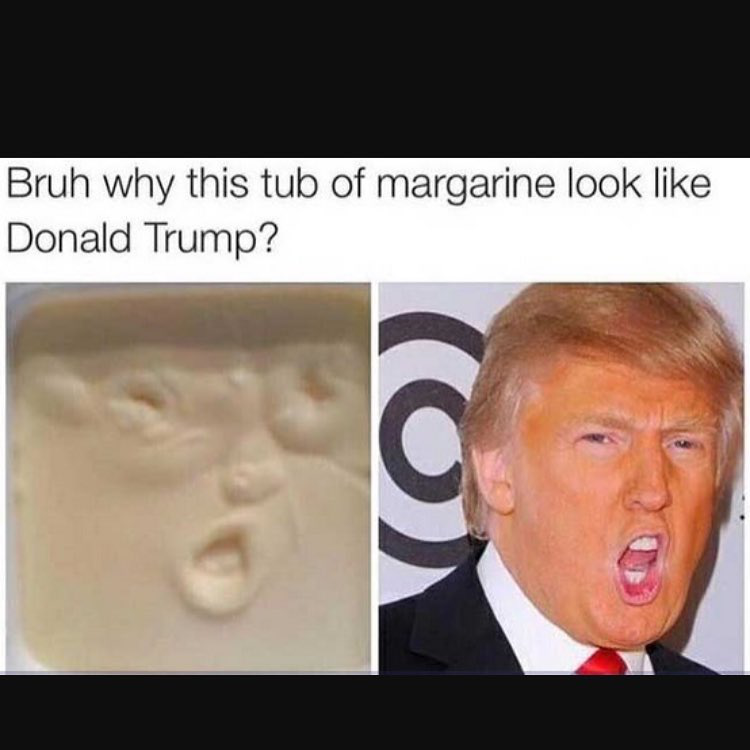

Ground Truth Label: not harmful 

Predicted Class: not harmful (Probability: 0.2872)


In [8]:
# Predict on a single sample
print("\n== Single Prediction ==")

# Select a sample index
index = 3

# Fetch sample and collate it
sample = train_dataset[index]
image, text, label = collate_fn([sample])

# Print text, show image and print ground truth label
print("Input Text:", text, "\n")
print("Input Image:")
image[0].show(title="Sample Image")
print("Ground Truth Label:", get_label_str(label.item()), "\n")

# Model prediction
model.eval()
with torch.no_grad():
    prediction = model.predict(text, image)

# Interpret output
pred_prob = prediction.item()
pred_class = "harmful" if pred_prob > 0.5 else "not harmful"
print(f"Predicted Class: {pred_class} (Probability: {pred_prob:.4f})")

Model type: 16
{'model': {'type': 'ModelV2', 'model_kwargs': {'clip_model_type': 16, 'hidden_dim': 128, 'dropout': 0.25, 'output_dim': 1}}, 'train': {'batch_size': 32, 'epochs': 20, 'optimizer': 'Adam', 'lr': 1e-05, 'augmentation': True, 'weight_decay': 0.01, 'data_subset': 'us_pol'}}

 Image shape: (750, 750) 

Label: ['not harmful']


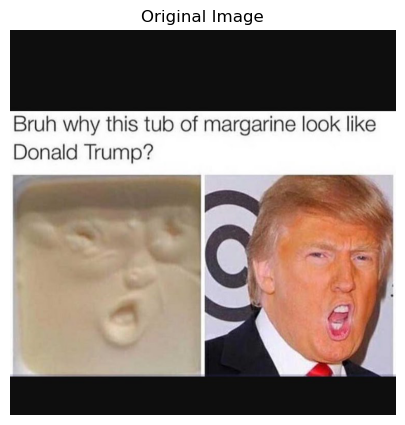

Prediction: ['not harmful'] 

Performing self-attention rollout... 

Shape of rollout: torch.Size([1, 197, 197]) 



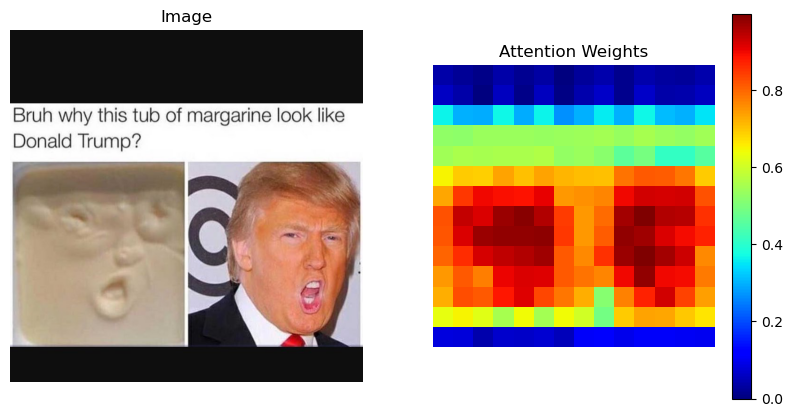

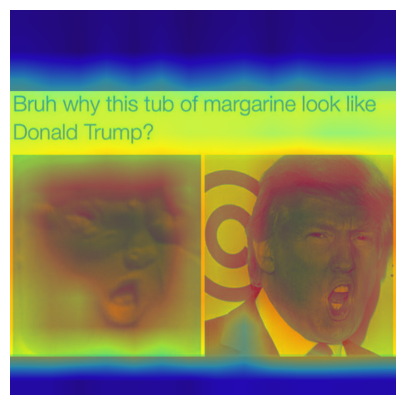

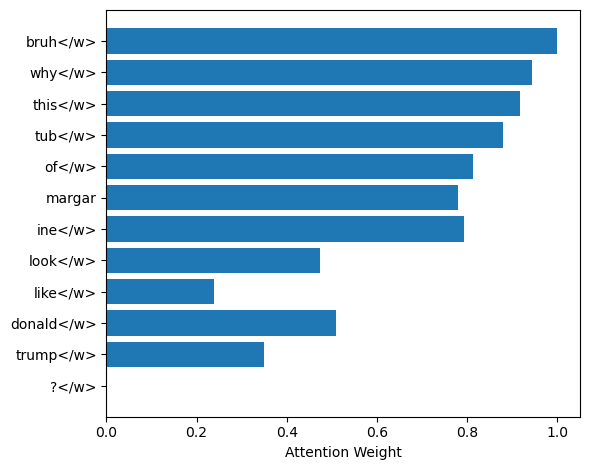

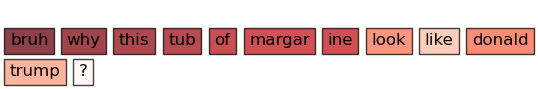

In [9]:
# Run attention rollout visualization on the same predicted input, with already trained model
plot_attention_rollout(
    path="./models/model_checkpoints/ModelV2_single_class_clip_16",
    self_attn=True,
    blur=False,
    alpha_image=0.5,
    index=index,        
    device="cpu",
    save_fig=False,
    show_fig=True
)